# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [6]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [7]:
# TODO: load the air temperature and precipitation datasets.
# Example: air = xr.open_dataset(..., chunks={"time": 8})
air = xr.open_dataarray(TEMP_URL, chunks={"time": 8})
precip = xr.open_dataarray(PRECIP_URL, chunks={"time": 8})

## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [8]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.
air_us = air.sel(time=TIME_RANGE, lat=slice(*LAT_RANGE), lon=slice(*LON_RANGE_360))
precip_us = precip.sel(time=TIME_RANGE, lat=slice(*LAT_RANGE), lon=slice(*LON_RANGE_360))

## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [9]:
# TODO: use xr.resample to create daily means.
air_daily = air_us.resample(time="1D").mean()


## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [10]:
# Interpolate the resampled temperature field onto the precipitation grid.
lat_slice = slice(LAT_RANGE[1], LAT_RANGE[0]) if air.lat.values[0] > air.lat.values[-1] else slice(LAT_RANGE[0], LAT_RANGE[1])
lat_slice_precip = slice(LAT_RANGE[1], LAT_RANGE[0]) if precip.lat.values[0] > precip.lat.values[-1] else slice(LAT_RANGE[0], LAT_RANGE[1])
air_us = air.sel(time=TIME_RANGE, lat=lat_slice, lon=slice(*LON_RANGE_360))
precip_us = precip.sel(time=TIME_RANGE, lat=lat_slice_precip, lon=slice(*LON_RANGE_360))

# Resample air temperature to daily means
air_daily = air_us.resample(time="1D").mean()
# Interpolate to precipitation grid
air_interp = air_daily.interp(
    lat=precip_us.lat,
    lon=precip_us.lon
)
air_interp

<xarray.DataArray 'air' (time: 30, lat: 60, lon: 140)> Size: 1MB
dask.array<transpose, shape=(30, 60, 140), dtype=float32, chunksize=(1, 60, 140), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]

## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [11]:
# TODO: build datasets and merge them into one object named `merged`.
merged = xr.merge([air_interp.rename("air"), precip_us.rename("precip")])

## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [12]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air", "precip"}
assert merged.air.dims == merged.precip.dims
print(merged)


<xarray.Dataset> Size: 2MB
Dimensions:  (time: 30, lat: 60, lon: 140)
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Data variables:
    air      (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    precip   (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


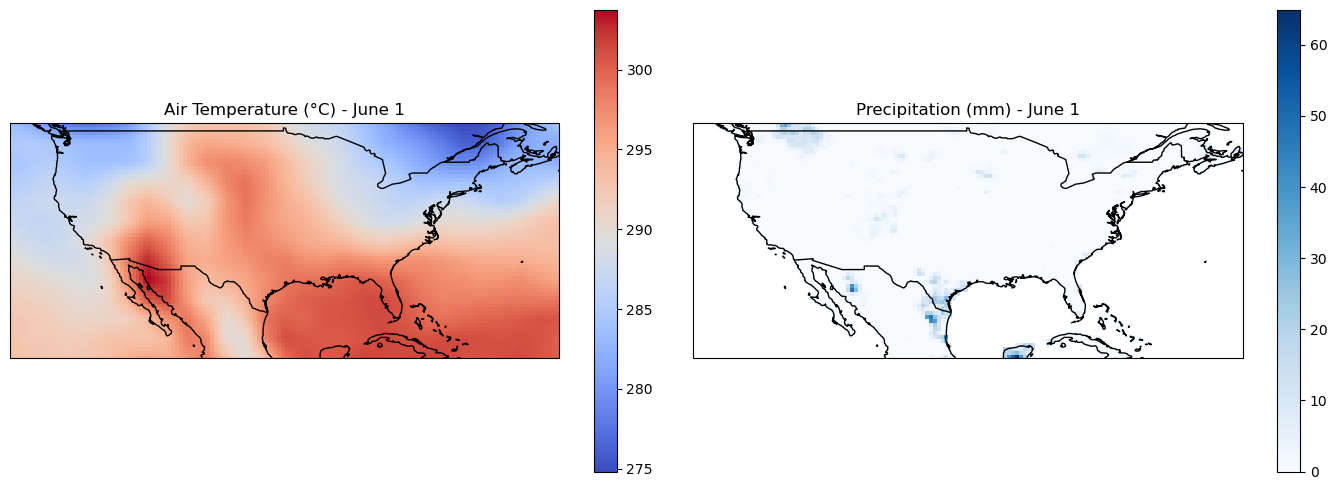

In [13]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot air temperature
air_plot = axes[0].pcolormesh(
        air_interp.lon, air_interp.lat, air_interp.isel(time=0),
        transform=ccrs.PlateCarree(), cmap="coolwarm"
)
axes[0].set_title("Air Temperature (°C) - June 1")
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS)
fig.colorbar(air_plot, ax=axes[0], orientation="vertical")

# Plot precipitation
precip_plot = axes[1].pcolormesh(
        precip_us.lon, precip_us.lat, precip_us.isel(time=0),
        transform=ccrs.PlateCarree(), cmap="Blues"
    )
axes[1].set_title("Precipitation (mm) - June 1")
axes[1].coastlines()
axes[1].add_feature(cfeature.BORDERS)
fig.colorbar(precip_plot, ax=axes[1], orientation="vertical")

plt.tight_layout()
plt.show()



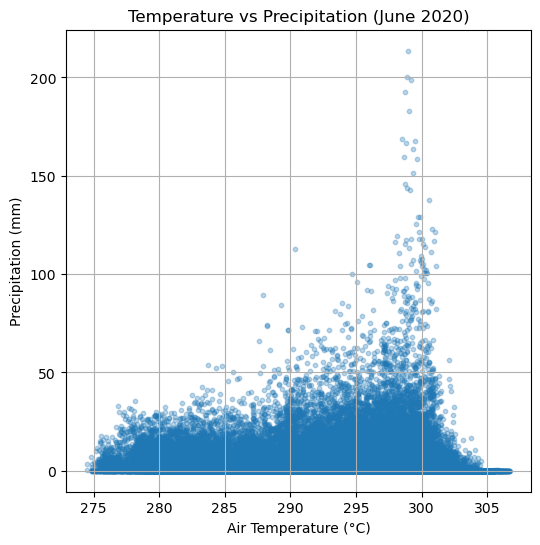

In [15]:
# Flatten and mask NaNs
temp_vals = air_interp.values.flatten()
precip_vals = precip_us.values.flatten()

mask = ~xr.ufuncs.isnan(temp_vals) & ~xr.ufuncs.isnan(precip_vals)

plt.figure(figsize=(6, 6))
plt.scatter(temp_vals[mask], precip_vals[mask], alpha=0.3, s=10)
plt.xlabel("Air Temperature (°C)")
plt.ylabel("Precipitation (mm)")
plt.title("Temperature vs Precipitation (June 2020)")
plt.grid(True)
plt.show()

In [17]:
# Merge and save
combined = xr.merge([
    air_interp.rename("air"),
    precip_us.rename("precip")
])

combined.to_netcdf("merged_climate_june2020.nc")